In [20]:
%matlab widget

import bagpy
from bagpy import bagreader

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

UsageError: Line magic function `%matlab` not found.


In [9]:
bag = bagreader("data/test1.bag")
#bag.topic_table

[INFO]  Data folder data/test1 already exists. Not creating.


In [10]:
accel_df = pd.read_csv(bag.message_by_topic('/imu/acceleration'))
accel_df.head(3)

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,vector.x,vector.y,vector.z
0,1.669803e+09,250,1669803320,423047544,imu_link,-1.434981,0.498791,9.674213
1,1.669803e+09,251,1669803320,428319850,imu_link,-1.426545,0.546572,9.681358
2,1.669803e+09,252,1669803320,432516182,imu_link,-1.436896,0.555246,9.700562


In [11]:
gyro_df = pd.read_csv(bag.message_by_topic('/imu/angular_velocity'))
gyro_df.head(3)

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,vector.x,vector.y,vector.z
0,1.669803e+09,250,1669803320,423047544,imu_link,0.003190,-0.004760,0.003020
1,1.669803e+09,251,1669803320,428319850,imu_link,-0.001221,-0.005975,-0.000975
2,1.669803e+09,252,1669803320,432516182,imu_link,0.001955,-0.001276,-0.003164


In [16]:
# get relevant data

accel_df['time_diff_ns'] = accel_df['header.stamp.secs'].diff(1) + accel_df['header.stamp.nsecs'].diff(1) / 1e9
timesteps = accel_df['time_diff_ns'].to_numpy()
vec_accel = accel_df[['vector.x', 'vector.y', 'vector.z']].to_numpy()
vec_gyro = gyro_df[['vector.x', 'vector.y', 'vector.z']].to_numpy()

# drop nan values
timesteps = timesteps[1:]
vec_accel = vec_accel[1:]
vec_gyro = vec_gyro[1:]

In [ ]:
# do calibrations and averaging


In [17]:
# do some integrations
vec_velocity = np.cumsum(vec_accel * timesteps[:,np.newaxis], axis=0)
vec_position = np.cumsum(vec_velocity * timesteps[:,np.newaxis], axis=0)


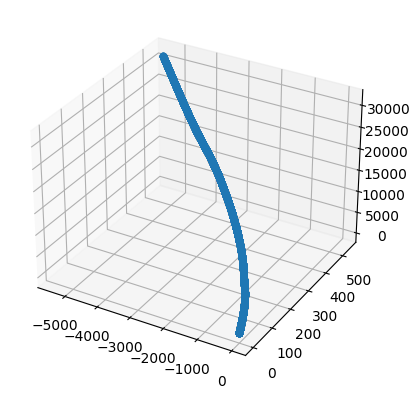

In [19]:
# plot it
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = vec_position[:, 0]
ydata = vec_position[:, 1]
zdata = vec_position[:, 2]

ax.scatter(xdata, ydata, zdata)
plt.show()